# Data preparation

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Image preprocessing: *variant 2*

1) Alignement between panchromatic and SWIR



2) Image tiling 
For each training and label images: (image_ms_pan, image_swir_pan) ~ (3348, 3391, 16), label_image ~ (3348, 3391, 10)
- Divide into tiles with overlapping
- Apply transformations: flip, ... keras preprocessing
- Normalize to [0, 1] 
- Save to file

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import cv2 

In [3]:
import sys
sys.path.append("../common/")

from data_utils import TRAIN_IMAGE_IDS, LABELS
from data_utils import get_filename, get_resized_polygons
from image_utils import generate_pansharpened, imwrite, generate_aligned_swir, generate_label_file
from visu_utils import display_img_1b
from geo_utils.GeoImage import GeoImage
from geo_utils.GeoImageTiler import GeoImageTiler

ImportError: cannot import name generate_label_file

In [20]:
import os
from image_utils import TRAIN_LABEL_TILES, TRAIN_DATA, get_tile_filename

Generate tiles : 17 bands images and 11 bands labels

In [21]:
tile_size = (512, 512)
overlapping = 64
include_nodata = False

resize_tiles = True
new_tile_size = (256, 256)

do_tile_images = True
do_tile_labels = True

for i, image_id in enumerate(TRAIN_IMAGE_IDS):
    print "--", image_id, i+1, "/", len(TRAIN_IMAGE_IDS)
    
    if do_tile_images:
        # Generate aligned swir file
        generate_aligned_swir(image_id)    

        # Generate pansharpened
        generate_pansharpened(image_id, 'ms')
        generate_pansharpened(image_id, 'swir_aligned')

    if do_tile_labels:
        # Generate label image
        generate_label_file(image_id, multi_dim=True)

    if do_tile_images:
        gimg_pan = GeoImage(get_filename(image_id, 'pan'))
        gimg_ms = GeoImage(get_filename(image_id, 'ms_pan'))
        gimg_swir = GeoImage(get_filename(image_id, 'swir_pan'))
    
    if do_tile_labels:
        gimg_label = GeoImage(get_filename(image_id, 'label'))
    
    if do_tile_images:
        gimg_pan_tiles = GeoImageTiler(gimg_pan, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
        gimg_ms_tiles = GeoImageTiler(gimg_ms, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
        gimg_swir_tiles = GeoImageTiler(gimg_swir, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    
    if do_tile_labels:
        gimg_label_tiles = GeoImageTiler(gimg_label, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    

    if do_tile_images:
        for tile_info_pan, tile_info_ms, tile_info_swir in \
                zip(gimg_pan_tiles, gimg_ms_tiles, gimg_swir_tiles):
    
            tile_pan, xoffset_pan, yoffset_pan = tile_info_pan
            tile_ms, xoffset_ms, yoffset_ms = tile_info_ms
            tile_swir, xoffset_swir, yoffset_swir = tile_info_swir

            h, w, _ = tile_pan.shape
            x = np.zeros((h, w, 17), dtype=np.uint16)
            x[:,:,0] = tile_pan[:,:,0]; x[:,:,1:9] = tile_ms; x[:,:,9:] = tile_swir

            if resize_tiles:
                x = cv2.resize(x, dsize=new_tile_size, interpolation=cv2.INTER_CUBIC)

            imwrite(get_tile_filename(image_id, xoffset_ms, yoffset_ms, '17b'), x)

    
    if do_tile_labels:
        for tile_info_label in gimg_label_tiles:

            tile_label, xoffset_label, yoffset_label = tile_info_label
            y = tile_label

            if resize_tiles:
                y = cv2.resize(y, dsize=new_tile_size, interpolation=cv2.INTER_LINEAR)

            imwrite(get_tile_filename(image_id, xoffset_label, yoffset_label, 'label'), y)    
        
        
if do_tile_images:   
    gimg_pan.close()
    gimg_ms.close()
    gimg_swir.close()

if do_tile_labels:
    gimg_label.close()

-- 6040_2_2 1 / 25


-- 6120_2_2 2 / 25


-- 6120_2_0 3 / 25


-- 6090_2_0 4 / 25


-- 6040_1_3 5 / 25


-- 6040_1_0 6 / 25


-- 6100_1_3 7 / 25


-- 6010_4_2 8 / 25


-- 6110_4_0 9 / 25


-- 6140_3_1 10 / 25


-- 6110_1_2 11 / 25


-- 6100_2_3 12 / 25


-- 6150_2_3 13 / 25


-- 6160_2_1 14 / 25


-- 6140_1_2 15 / 25


-- 6110_3_1 16 / 25


-- 6010_4_4 17 / 25


-- 6170_2_4 18 / 25


-- 6170_4_1 19 / 25


-- 6170_0_4 20 / 25


-- 6060_2_3 21 / 25


-- 6070_2_3 22 / 25


-- 6010_1_2 23 / 25


-- 6040_4_4 24 / 25


-- 6100_2_2 25 / 25


Check label images

In [22]:
import os
from glob import glob
from image_utils import get_image_tile_data

all_train_tiles = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_DATA)+1:] for s in all_train_tiles])

for j, tile_id in enumerate(all_train_tiles):
    y = get_image_tile_data(os.path.join(TRAIN_LABEL_TILES,tile_id))
    print "Tile id: ", tile_id, j+1, len(all_train_tiles), y.shape, y.min(), y.max()
    if y.max() > 1.0:
        
        for i in range(y.shape[2]):
            if y[:,:,i].max() > 1.0:
                plt.figure(figsize=(12,4))
                display_img_1b(y[:,:,i])
                print y[:,:,i].min(), y[:,:,i].max(), np.unique(y[:,:,i])
                assert False, "Y[:,:,%i] max > 1.0" % i


Tile id:  6010_1_2_0_0.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_0_1280.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_0_1728.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_0_2176.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_0_2624.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_0_3072.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_0_384.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_0_832.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1280_0.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1280_1280.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1280_1728.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1280_2176.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1280_2624.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1280_3072.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1280_384.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1280_832.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1728_0.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1728_1280.tif (256L, 256L, 11L) 0 1
Tile id:  6010_1_2_1728_1728.tif (256L, 256L, 1

Create mean / std tile for a dataset

In [55]:
import os
from glob import glob
all_train_tiles = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_DATA)+1:] for s in all_train_tiles])

In [67]:
from image_utils import get_image_tile_data

trainset_ids = all_train_tiles[:256]

ll = len(trainset_ids)
tile_id = trainset_ids[0]
tile = get_image_tile_data(os.path.join(TRAIN_DATA,tile_id)).astype(np.float)
# Init mean/std images
mean_tile_image = np.zeros_like(tile)
std_tile_image = np.zeros_like(tile)

mean_tile_image += tile
std_tile_image += np.power(tile, 2)

for i, tile_id in enumerate(trainset_ids[1:]):
    print "--", i+1, tile_id
    tile = get_image_tile_data(os.path.join(TRAIN_DATA,tile_id)).astype(np.float)
    mean_tile_image += tile
    std_tile_image += np.power(tile, 2)
    
    
mean_tile_image *= 1.0/ll
std_tile_image *= 1.0/ll
std_tile_image -= np.power(mean_tile_image, 2)

-- 0 6010_1_2_0_1280.tif
-- 1 6010_1_2_0_1728.tif
-- 2 6010_1_2_0_2176.tif
-- 3 6010_1_2_0_2624.tif
-- 4 6010_1_2_0_3072.tif
-- 5 6010_1_2_0_384.tif
-- 6 6010_1_2_0_832.tif
-- 7 6010_1_2_1280_0.tif
-- 8 6010_1_2_1280_1280.tif
-- 9 6010_1_2_1280_1728.tif
-- 10 6010_1_2_1280_2176.tif
-- 11 6010_1_2_1280_2624.tif
-- 12 6010_1_2_1280_3072.tif
-- 13 6010_1_2_1280_384.tif
-- 14 6010_1_2_1280_832.tif
-- 15 6010_1_2_1728_0.tif
-- 16 6010_1_2_1728_1280.tif
-- 17 6010_1_2_1728_1728.tif
-- 18 6010_1_2_1728_2176.tif
-- 19 6010_1_2_1728_2624.tif
-- 20 6010_1_2_1728_3072.tif
-- 21 6010_1_2_1728_384.tif
-- 22 6010_1_2_1728_832.tif
-- 23 6010_1_2_2176_0.tif
-- 24 6010_1_2_2176_1280.tif
-- 25 6010_1_2_2176_1728.tif
-- 26 6010_1_2_2176_2176.tif
-- 27 6010_1_2_2176_2624.tif
-- 28 6010_1_2_2176_3072.tif
-- 29 6010_1_2_2176_384.tif
-- 30 6010_1_2_2176_832.tif
-- 31 6010_1_2_2624_0.tif
-- 32 6010_1_2_2624_1280.tif
-- 33 6010_1_2_2624_1728.tif
-- 34 6010_1_2_2624_2176.tif
-- 35 6010_1_2_2624_2624.tif
-- 36 6

In [68]:
print mean_tile_image.dtype, mean_tile_image.min(), mean_tile_image.max()
print std_tile_image.dtype, std_tile_image.min(), std_tile_image.max()

float64 337.3203125 689.28125
float64 184.779052734 17718.3825684


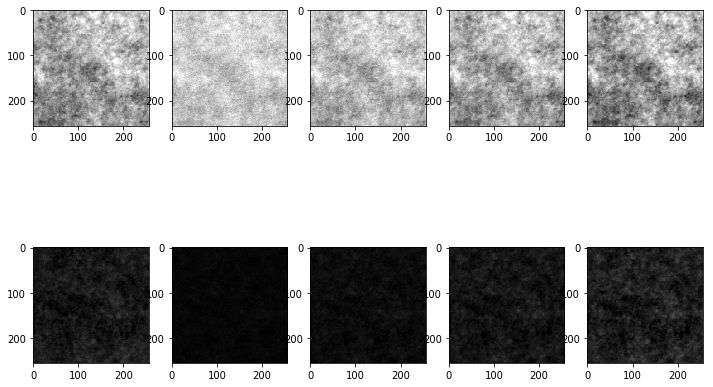

In [75]:
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    display_img_1b(mean_tile_image[:,:,i])

for i in range(5):
    plt.subplot(2,5,5+i+1)
    display_img_1b(std_tile_image[:,:,i])

count += 5

In [117]:
def inversion(tile):
    inv_tile = tile + tile.min() + 100
    eps = 1e-7
    inv_tile = np.power(inv_tile+eps, -1.0)
    mean = np.mean(inv_tile)
    std = np.std(inv_tile)
    inv_tile = (inv_tile - mean)/std
    return inv_tile

In [84]:
count = 0

-- 0 6010_4_4_3072_1728.tif -0.232726256788 0.176870446737 (256L, 256L, 17L)
-- 1 6010_4_4_3072_2176.tif -0.246076510752 0.143217154541 (256L, 256L, 17L)
-- 2 6010_4_4_3072_2624.tif -0.241625480505 0.290977790965 (256L, 256L, 17L)
-- 3 6010_4_4_3072_3072.tif -0.20921606634 0.253230111867 (256L, 256L, 17L)
-- 4 6010_4_4_3072_384.tif -0.238901890141 0.204530204508 (256L, 256L, 17L)


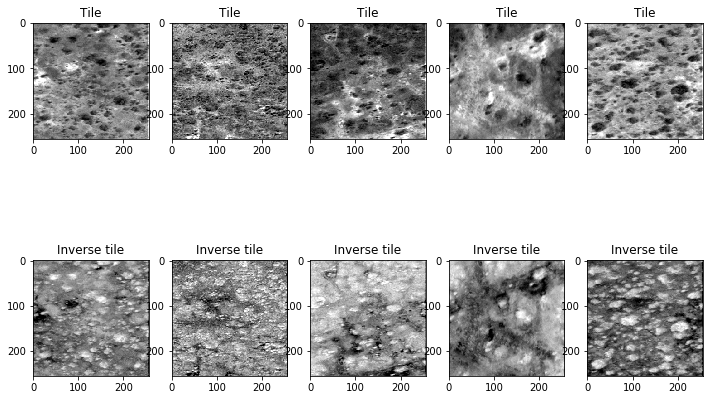

In [125]:
plt.figure(figsize=(12,8))
for i, tile_id in enumerate(trainset_ids[count:count+5]):
    
    tile = get_image_tile_data(os.path.join(TRAIN_DATA,tile_id)).astype(np.float)
    tile -= mean_tile_image
    tile /= std_tile_image
    
    inv_tile = inversion(tile)   
    
    print "--", i, tile_id, tile.min(), tile.max(), tile.shape
    plt.subplot(2,5,i + 1)
    display_img_1b(tile[:,:,i])
    plt.title("Tile")
    
    plt.subplot(2,5,5 + i + 1)
    display_img_1b(inv_tile[:,:,i])
    plt.title("Inverse tile")

    
count += 5

In [41]:
615  **2

378225

In [38]:
# from data_utils import generate_label_image2
# img_label = generate_label_image2('6120_2_0')
# print img_label.shape, img_label.dtype,  img_label.min(), img_label.max()

In [12]:
gimg_label = GeoImage(get_filename('6010_1_2', 'label'))
img_label = gimg_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max()

(3348L, 3396L, 11L) uint8 0 1


In [13]:
gimg_label = GeoImage(get_filename('6110_3_1', 'label'))
img_label = gimg_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max()

(3348L, 3396L, 11L) uint8 0 1


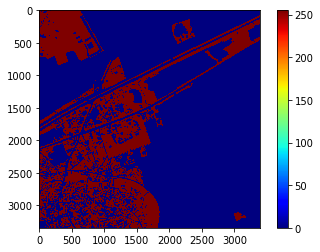

In [142]:
plt.figure()
display_img_1b(img_label[:,:,0], cmap=plt.get_cmap('jet'))
plt.colorbar()

In [143]:
gimg_test = GeoImage(TRAIN_DATA + '/6120_2_0_1280_1728.tif')
img = gimg_test.get_data()
print img.shape, img.dtype, img.min(), img.max()

gimg_test_label = GeoImage(TRAIN_LABEL_TILES + '/6120_2_0_1280_1728.tif')
img_label = gimg_test_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max()


(256L, 256L, 17L) uint16 311 1148
(256L, 256L, 11L) uint8 0 199


ERROR! Session/line number was not unique in database. History logging moved to new session 476


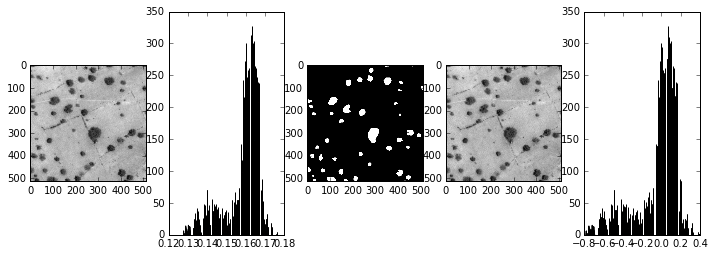

In [17]:
nimg = img * 1.0/2**12
nnimg = (img - np.mean(img))/np.std(img)
plt.figure(figsize=(12,4))
plt.subplot(151)
plt.imshow(nimg[:,:,0], cmap='gray')
plt.subplot(152)
plt.hist(nimg[:,:,0])
plt.subplot(153)
plt.imshow(img_label[:,:,5], cmap='gray')
plt.subplot(154)
plt.imshow(nnimg[:,:,0], cmap='gray')
plt.subplot(155)
_ = plt.hist(nnimg[:,:,0])

In [132]:
gimg_test = GeoImage(TRAIN_DATA + '/6110_3_1_1280_1728.tif')
gimg_test = GeoImage(TRAIN_DATA + '/6110_3_1_1280_1728.tif')

img = gimg_test.get_data()
print img.shape, img.dtype, img.min(), img.max()

gimg_test_label = GeoImage(TRAIN_LABEL_TILES + '/6110_3_1_1280_1728.tif')
img_label = gimg_test_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max() 


(256L, 256L, 17L) uint16 197 2304
(256L, 256L, 11L) uint8 0 255


In [136]:
for i in range(img_label.shape[2]):
    print i, img_label[:,:,i].min(), img_label[:,:,i].max()

0 0 1
1 0 1
2 0 1
3 0 0
4 0 0
5 0 1
6 0 1
7 0 0
8 0 255
9 0 253
10 0 254


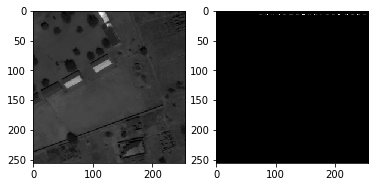

In [138]:
nimg = img * 1.0/2**12
plt.figure()
plt.subplot(121)
plt.imshow(nimg[:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(img_label[:,:,10], cmap='gray')

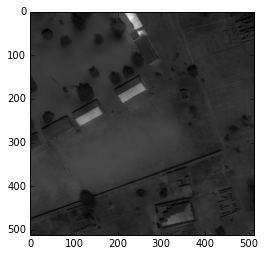

In [46]:
from image_utils import get_image_tile_data

img = get_image_tile_data(TRAIN_DATA + '/6110_3_1_1280_1728.tif')

nimg = img * 1.0/2**12
plt.figure()
plt.imshow(nimg[:,:,16], cmap='gray')

In [47]:
from image_utils import get_image_data
label_img = get_image_data("6100_2_2", 'label')
label_img.shape

(3348, 3391, 11)

In [9]:

def normalize_image(img_data, interp=cv2.INTER_CUBIC):
    img_data = cv2.resize(img_data, dsize=(512, 512), interpolation=interp)
    out = np.zeros_like(img_data)
    for c in range(img_data.shape[2]):        
        min_value, max_value, _, _ = cv2.minMaxLoc(img_data[:,:,c])
        out[:,:,c] = (img_data[:,:,c] - min_value)/(max_value - min_value + 0.0001)            
    out = out.transpose([2,0,1])
    out = out[None,:]
    return out

In [19]:
gimg_test = GeoImage(TRAIN_DATA + '/6120_2_0_1280_1728.tif')
img = gimg_test.get_data()
print img.shape, img.dtype, img.min(), img.max()

(512, 512, 17) uint16 308 1153


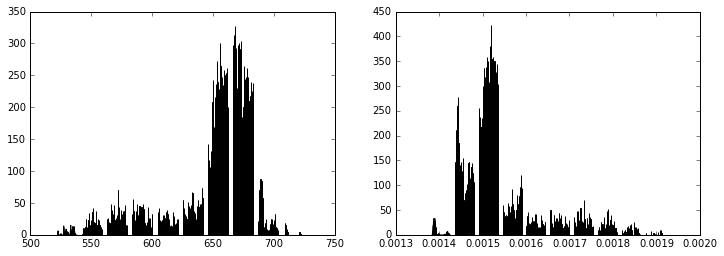

In [20]:
inv_img = 1.0/img

plt.figure(figsize=(12,4))
plt.subplot(121)
_ = plt.hist(img[:,:,0])
plt.subplot(122)
_ = plt.hist(inv_img[:,:,0])

Generate 1-band labels and 17 bands image tiles

In [18]:
# tile_size = (512, 512)
# overlapping = 64
# include_nodata = True

# for i, image_id in enumerate(TRAIN_IMAGE_IDS):
#     print "--", image_id, i, "/", len(TRAIN_IMAGE_IDS)
    
#     # Generate aligned swir file
#     generate_aligned_swir(image_id)    
    
#     # Generate pansharpened
#     generate_pansharpened(image_id, 'ms')
#     generate_pansharpened(image_id, 'swir_aligned')
#     # Generate label image
#     generate_label_file(image_id, multi_dim=False)

#     gimg_pan = GeoImage(get_filename(image_id, 'pan'))
#     gimg_ms = GeoImage(get_filename(image_id, 'ms_pan'))
#     gimg_swir = GeoImage(get_filename(image_id, 'swir_pan'))
#     gimg_label = GeoImage(get_filename(image_id, 'label_1d'))
    
#     gimg_pan_tiles = GeoImageTiler(gimg_pan, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
#     gimg_ms_tiles = GeoImageTiler(gimg_ms, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
#     gimg_swir_tiles = GeoImageTiler(gimg_swir, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
#     gimg_label_tiles = GeoImageTiler(gimg_label, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    
#     for tile_info_pan, tile_info_ms, tile_info_swir, tile_info_label in \
#             zip(gimg_pan_tiles, gimg_ms_tiles, gimg_swir_tiles, gimg_label_tiles):
    
#         tile_pan, xoffset_pan, yoffset_pan = tile_info_pan
#         tile_ms, xoffset_ms, yoffset_ms = tile_info_ms
#         tile_swir, xoffset_swir, yoffset_swir = tile_info_swir
#         tile_label, xoffset_label, yoffset_label = tile_info_label

#         h, w, _ = tile_pan.shape
#         x = np.zeros((h, w, 17), dtype=np.uint16)
#         x[:,:,0] = tile_pan[:,:,0]; x[:,:,1:9] = tile_ms; x[:,:,9:] = tile_swir
#         imwrite(get_tile_filename(image_id, xoffset_ms, yoffset_ms, '17b'), x)
#         y = tile_label
#         imwrite(get_tile_filename(image_id, xoffset_label, yoffset_label, 'label_1d'), y)    